In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:


class Labeled_dataset(torch.utils.data.Dataset):
    "Characterizes a dataset for labeled segmentation dataset"

    def __init__(
        self,
        patient_list,
        input_dir,
        augmentation_params=None,
        transform=None,
        verbose=True,
        return_file_loc=False,
    ):
        """
        :param patient_list: list or set of patient ids to include in dataset
        :param input_dir: directory where data is stored. This directory should contain a folder for each patient,
                            which in turn contains one file for each recording. Each file should be a .npy file
                            containing a tuple of the ultrasound image and its segmentation mask as a numpy arrays.
        :param augmentation_params: list of augmentation parameters
        :param verbose: whether to print information about dataset
        :param return_file_loc: whether to return file location of sample when loading data
        """
        self.verbose = verbose
        self.patient_list = patient_list
        self.input_dir = input_dir
        self.init_index_to_file_dict()
        self.return_file_loc = return_file_loc
        self.transform = transform
        if augmentation_params is None:
            self.augmentations = None
        else:
            self.augmentations = augmentations.get_augmentation_funcs(
                augmentation_params
            )
        # list the transforms
        if self.transform is not None:
            print("Transforms:")
            for transform in self.transform:
                print(f"    {transform.__class__.__name__}")

    def __len__(self):
        "Denotes the total number of patients"
        return len(self.list_IDs)

    def __getitem__(self, custom_index=None):
        """
        'Generates one sample of data'
        :param custom_index: index of sample to load. If None, a random sample will be loaded
        :return: X,y, the sample (ultrasound image) and its label (segmentation mask) as 2D numpy arrays
        """
        if custom_index is None:
            index = self.index
        else:
            index = custom_index
        # Generate data
        if self.return_file_loc:
            X, y, file_loc = self.__data_generation(index)
        else:
            X, y = self.__data_generation(index)
        y = np.squeeze(y)

        if self.augmentations is not None:
            X, y = augmentations.apply_augmentations((X, y), self.augmentations)

        # this is where the actual augmentation happens
        if self.transform is not None:
            transformed = self.transform(image=X, mask=y)
            X = transformed["image"]
            y = transformed["mask"]
        # if isinstance(X, list):
        #     X = [torch.from_numpy(x) for x in X]
        # else:
        #     X = torch.from_numpy(X)

        if self.return_file_loc:
            return X, y, file_loc
        else:
            return X, y

    def __data_generation(self, index):
        "Generates data containing batch_size samples"  # X : (n_samples, *dim)
        # Generate data
        file_loc = self.index_to_file_dict[index]
        X, y = np.load(file_loc, allow_pickle=True)
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        if self.return_file_loc:
            return X, y, file_loc
        else:
            return X, y

    def init_index_to_file_dict(self):
        """
        Initializes a dictionary mapping index to file location. The index is used by the pytorch dataloader to
        load samples. The file location is used to retrieve the file location of a sample when loading data.
        The function sets the following attributes:
            - self.index_to_file_dict: dictionary mapping index to file location
            - self.list_IDs: list of indices
        """
        self.index_to_file_dict = {}
        index = 0
        for patient_id in os.listdir(self.input_dir):
            if patient_id in self.patient_list:
                patient_dir = os.path.join(self.input_dir, patient_id)
                for recording in os.listdir(patient_dir):
                    recording_path = os.path.join(patient_dir, recording)
                    self.index_to_file_dict[index] = recording_path
                    index += 1
        if self.verbose:
            print("Number of recordings in dataset:" + str(index))
        self.list_IDs = np.arange(index)


if __name__ == "__main__":
    import augmentations

    print("hallo fra datasettet!")
    # example usage
    input_dir = "../preprocessing_output/cv1/train_val"
    splits = utils.get_splits(1, "../../local_data/subgroups_CAMUS")
    train_set, val_set, test_set = splits
    params = {"batch_size": 1, "shuffle": True, "num_workers": 1}
    augmentation_params = []
    means = []
    stds = []
    train_transform = A.Compose(
        [
            # A.ShiftScaleRotate(
            #     shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5
            # ),
            # A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            # A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            # A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
            # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            # A.Normalize(mean=(0.485), std=(0.229)),
            # A.Normalize(mean=(48.6671), std=(53.9987), max_pixel_value=1.0),
            ToTensorV2(),
        ]
    )
    dataset_train_pytorch = Labeled_dataset(
        train_set,
        input_dir,
        augmentation_params=augmentation_params,
        verbose=True,
        transform=train_transform,
    )
    dataloader = torch.utils.data.DataLoader(dataset_train_pytorch, **params)
    train_iterator_pytorch = iter(dataloader)
    X, y = next(train_iterator_pytorch)
    y_one_hot = utils.convert_to_one_hot(y)
    X = X.squeeze()
    print(X.shape)
    print(y.shape)
    print(X[0].min(), X[0].max())
    print(y[0].min(), y[0].max())

    # find mean and std for entire dataset
    # for i in range(len(dataset_train_pytorch)):
    #     X, y = dataset_train_pytorch[i]
    #     means.append(X.mean().item())
    #     stds.append(X.std().item())

    # plotting some samples
    # for i in range(3):
    #     X, y = next(train_iterator_pytorch)
    #     X = X.squeeze()
    #     plt.imshow(X[0].T, cmap="gray")
    #     plt.savefig("test.png")
    #     plt.show()
    #     plt.imshow(y[0].T, cmap="gray")
    #     plt.show()
    #     visualization = utils.create_visualization(X[0].T, y[0].T)
    #     plt.imshow(visualization)
    #     plt.show()
    #     plt.clf()

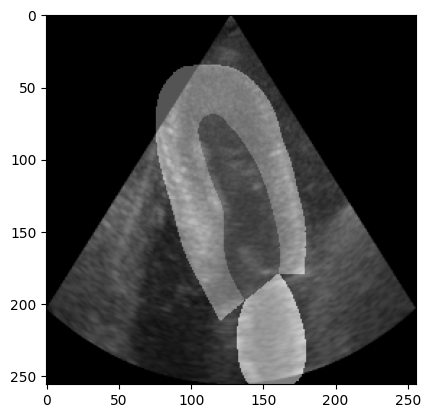

In [7]:
plt.imshow(X.T, cmap="gray")
plt.imshow(y[0].T, cmap="gray", alpha=0.5)

In [11]:
np.mean(means), np.mean(stds)

(48.667148208618165, 53.99869374036789)

In [9]:
y[0].unique(return_counts=True)

(tensor([0., 1., 2., 3.]), tensor([49858,  3960,  8866,  2852]))

In [62]:
folder = "/home/andekje/masters-thesis/unet1/preprocessing_output/HUNT4_data/HUNT4_a2c_a4c_numpy_original_size"
# create a list of all the subfolders
# subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
# create a list of the path of all the .npy files in folder
image_paths = []
for root, subdirs, files in os.walk(folder):
    for file in files:
        if file.endswith("gt.npy"):
            image_paths.append(os.path.join(root, file))

In [68]:
# split the into train, val and test
np.random.seed(42)
np.random.shuffle(image_paths)
train_paths = image_paths[: int(0.8 * len(image_paths))]
val_paths = image_paths[int(0.8 * len(image_paths) + 1) : int(0.9 * len(image_paths))]
test_paths = image_paths[int(0.9 * len(image_paths)) :]

# save the splits as text files
with open(
    "/home/andekje/masters-thesis/unet1/preprocessing_output/HUNT4_data/train.txt",
    "w",
) as f:
    for path in train_paths:
        f.write(path + "\n")

with open(
    "/home/andekje/masters-thesis/unet1/preprocessing_output/HUNT4_data/val.txt", "w"
) as f:
    for path in val_paths:
        f.write(path + "\n")

with open(
    "/home/andekje/masters-thesis/unet1/preprocessing_output/HUNT4_data/test.txt",
    "w",
) as f:
    for path in test_paths:
        f.write(path + "\n")


In [84]:
class Hunt4Dataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

        if self.transform is not None:
            print("Transforms:")
            for transform in self.transform:
                print(f"    {transform.__class__.__name__}")

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        X = np.load(self.file_paths[idx].replace("_gt", ""), allow_pickle=True)
        y = np.load(self.file_paths[idx], allow_pickle=True)
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        if self.transform is not None:
            transformed = self.transform(image=X, mask=y)
            X = transformed["image"]
            y = transformed["mask"]
        return X, y

In [85]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
        [
            A.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=(-0.2, 0.1), rotate_limit=10, p=0.5
            ),
            ToTensorV2(),
        ]
    )

dataset = Hunt4Dataset(train_paths, transform=train_transform)

Transforms:
    ShiftScaleRotate
    ToTensorV2


In [86]:
X = dataset[0][0]
y = dataset[0][1]

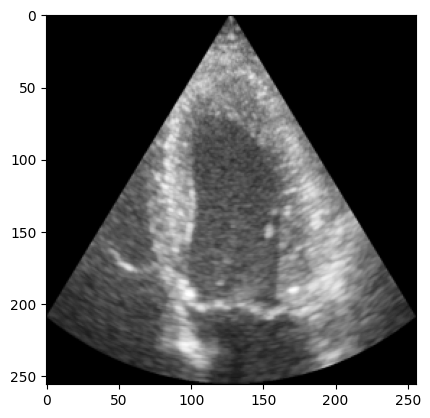

In [88]:
plt.imshow(X.squeeze(), cmap="gray")

In [4]:
X_path = "/home/andekje/masters-thesis/unet1/preprocessing_output/HUNT4_data/HUNT4_a2c_a4c_numpy_original_size/0004/HAND8R94/US-2D_155.npy"
Y_path = "/home/andekje/masters-thesis/unet1/preprocessing_output/HUNT4_data/HUNT4_a2c_a4c_numpy_original_size/0004/HAND8R94/US-2D_155_gt.npy"
# X_path = "/home/andekje/masters-thesis/unet1/preprocessing_output/cv1/train_val/patient0025/patient0025_4CH_ED.npy"
# Y_path = "/home/andekje/masters-thesis/unet1/preprocessing_output/cv1/train_val/patient0011/patient0011_2CH_ES.npy"
X = np.load(X_path, allow_pickle=True)
Y = np.load(Y_path, allow_pickle=True)
X.shape, Y.shape

EOFError: No data left in file

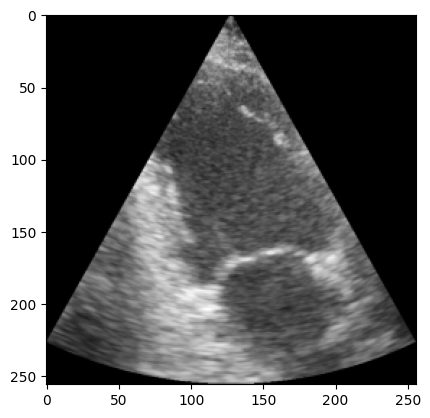

In [56]:
plt.imshow(X, cmap="gray")

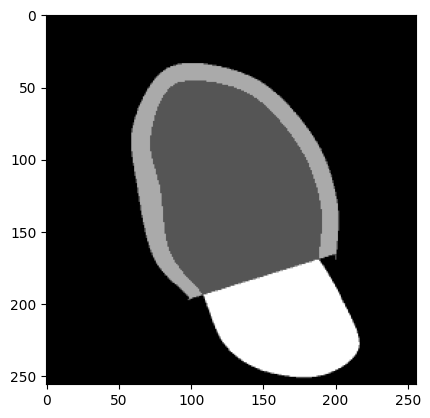

In [57]:
plt.imshow(Y, cmap="gray")